<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>Автор материала: @vfdev

In [1]:
from IPython.display import display, Math, Latex
from IPython.core.display import HTML 

# Итеративная стратификация данных с пересекающимися классами
Iterative stratification of multi-label data

## О чем речь - TL;DR

Есть данные, например, документы (`X`) и их теги (`y`). Естественно, что каждый документ может иметь сразу несколько тегов. Для обучения моделей важно уметь "сбалансированно" разбивать выборку на тренировочную и проверочную. 
Далее, рассмотрим один методов такого разбиения: iterative stratification и небольшую [библиотеку](https://github.com/trent-b/iterative-stratification), реализующую алгоритм на Python.

**Исходные данные:**

instance | tag_0 | tag_1 | tag_2 | ... | tag_9
---|---|---|---|---|--- 
a | 0 | 0 | 1 | ... | 0
b | 0 | 1 | 1 | ... | 1
c | 1 | 0 | 1 | ... | 0
... | ... | ... | ... | ...

**Разбиение на тренировочную и проверочную выборки**

<img src="../../img/iterative_stratification_of_multilabel_data_tldr.png">


## Теория

**Кросс-валидация** (кросс-проверка, скользящий контроль) используется для оценивания обобщающей способности алгоритмов и является также полезной процедурой для выявления переобучения. При этом, в зависимости от качества (сбалансированности) исходных данных, очень важен метод разбиения исходной выборки на обучающую и проверочную. В этом курсе мы видели несколько вариантов такого разбиения: 
- случайное разбиение (`sklearn.model_selection.KFold`) для сбалансированных данных
- стратификационное разбиение (`sklearn.model_selection.StratifiedKFold`)
  - сохраняет пропорции присутствия непересекающихся классов в обучающей и проверочной выборках
- разбиение временных рядов (`sklearn.model_selection.TimeSeriesSplit`)

Понятно, что в зависимости от типа данных следует применять то или иное разбиение. Итак, у нас есть данные, в которых целевая переменная $y$ является вектором $(y_0, y_1, ..., y_{K-1})$, где $y_i = \{0, 1\}$. Мы хотим разбить эти данные на две подвыборки, сохранив приблизительно одинаковое распределение классов. В этой тетрадке мы познакомимся с одним из методов стратификационного разбиение для данных с пересекающимися классами.

**Что делать с тегами?** Варианты, как работать с данными с пересекающимися классами, могут быть разные. Хотя их рассмотрение и не входит в тему этого обзора, но приведем несколько примеров:
- преобразование начальной задачи в проблему многоклассовой классификации: *теги -> непересекающиеся классы*
  - Binary relevence: преобразует K тегов в K бинарных наборов данных, по одному набору данных на каждый тег
  - Label Powerset: преобразует уникальные комбинации тегов в непересекающиеся классы, `(0, 1, 0, 1) -> 5`  
- использование алгоритмов, способных работать с начальной задачей (с тегами) 
  - Решающие деревья
  - kNN
  - Нейронные сети
  
Более подробно об этом можно почитать по ссылкам:
- [Multi-label classification](https://en.wikipedia.org/wiki/Multi-label_classification)
- [Multi-Label Classification: An Overview](http://lpis.csd.auth.gr/publications/tsoumakas-ijdwm.pdf)
- [Решающие правила для ансамбля из цепей
вероятностных классификаторов при решении задач
классификации с пересекающимися классами](http://jmlda.org/papers/doc/2016/JMLDA2016no3.pdf)
- [Sklearn - Support multilabel](http://scikit-learn.org/stable/modules/multiclass.html)


### Итеративная стратификация

Это метод разбиения исходной выборки $D(X, y)$ с пересекающимися $K$ классами на $n$ непересекающихся наборов. 
Также как и в обычном методе многоклассовой стратификации, результат разбиение $S_1$, $S_2$ ... $S_n$, можно преобразовать в обучающую и тестовую подвыборки: для $i=1,...,n$ тестовая выборка - $S_i$, а обучающая подвыборка есть объединение $S_1$, ..., $S_{i-1}$, $S_{i+1}$, ... $S_n$.

**Основные этапы алгоритма**: 

1) *Всем подвыборкам одинаковое количество элементов!* 

Задать число элементов $c_i$ для каждой подвыборки $S_i$, например, $c_i = \frac{N}{n},$ где $N$ - это количество примеров в изначальной выборке $D$.

2) *Всем подвыборкам одинаковое распределение классов!*  

Посчитать число примеров $c^j_i$, содержащих класс $j$ в подвыборке $S_i$: $c^j_i = \frac{D_j}{n},$ где $D_i$ число элементов исходной выборки, содержащих класс $j$. 
 
3) *Раздать все элементы исходной выборки, начиная с самых редких в самые нуждающиеся подвыборки!* 

Далее, элементы исходной выборки распределяются по подвыборкам следующим образом:
  - Из оставшихся элементов $D$ найти такие $(x, y)$ с самым редко встречающимся классом (исключая ноль, как отсутствие класса). Назовем найденный класс $l$.
  - Из заполненных подвыборок найти такую $S_i$, в которой присутствует наименьшее количество элементов с выбранным классом $l$: $i = \text{argmax}_k(c^l_k)$
  - Занести элемент в подвыборку $S_i$ и убрать из исходной выборки $D$. А также внести правки в $c^j_i$ и $c_i$.

Более подробное описание алгоритма, а также разбор нюансов можно найти в статье [авторов алгоритма](http://lpis.csd.auth.gr/publications/tsoumakas-ijdwm.pdf). Далее в практической части, рассмотрим реализацию этого алгоритма в интерактивном режиме.


## Практика

В этой части мы рассмотрим итеративную стратификацию на конкретном примере. Мы будем использовать библиотеку [iterative-stratification](https://github.com/trent-b/iterative-stratification). Чтобы установить ее, просто выполните команду:

In [2]:
!pip3 install iterative-stratification

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Итак, возьмем для примера выборку `stackoverflow_sample_125k.tsv`, которая состоит из вопросов и тегов. Мы имеем 125000 вопросов и 10 уникальных тегов : 'android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript', 'jquery', 'php', 'python'.

Загрузим данные и добавим теги отдельными колонками.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [4]:
data = pd.read_csv("../../data/stackoverflow_sample_125k.tsv", sep="\t", header=None)
data.columns = ["sample", "tags"]
unique_tags = ['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript', 'jquery', 'php', 'python']
tags = np.zeros((len(data), len(unique_tags)), dtype=np.uint8)

for i, vals in enumerate(data['tags'].str.split(" ").values):
    for v in vals:
        tags[i, unique_tags.index(v)] = 1

data = pd.concat([data, pd.DataFrame(tags, columns=unique_tags)], axis=1)

print(data.shape)
data.head()

(125000, 12)


,sample,tags,android,c#,c++,html,ios,java,javascript,jquery,php,python
0,i ve got some code in window scroll that check...,javascript jquery,0,0,0,0,0,0,1,1,0,0
1,i have a custom adapter for a list view it has...,android,1,0,0,0,0,0,0,0,0,0
2,in my form panel i added a checkbox setting st...,javascript,0,0,0,0,0,0,1,0,0,0
3,i have the two dates variables startwork and e...,c#,0,1,0,0,0,0,0,0,0,0
4,i might have been using the wrong search tags ...,android,1,0,0,0,0,0,0,0,0,0


На самом деле, данная выборка настолько хорошо сбалансирована, что даже при случайном разбиении на поднаборы распределение классов визуально одинаковое:

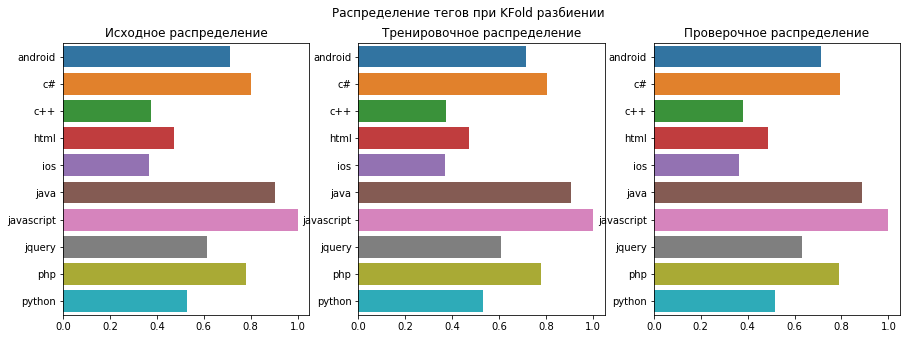

In [5]:
from sklearn.model_selection import KFold


def display_kfold_split(data):

    splt = KFold(n_splits=5, shuffle=True, random_state=12345)

    y = np.arange(len(data))
    X = np.zeros((len(data), 1))

    for train_index, test_index in splt.split(X, y):
        break

    tags_counts = data[unique_tags].sum(axis=0)
    tags_counts = tags_counts / tags_counts.max()

    train_tags_counts = data.loc[train_index, unique_tags].sum(axis=0)
    train_tags_counts = train_tags_counts / train_tags_counts.max()

    test_tags_counts = data.loc[test_index, unique_tags].sum(axis=0)
    test_tags_counts = test_tags_counts / test_tags_counts.max()

    fig = plt.figure(figsize=(15, 5))
    plt.suptitle("Распределение тегов при KFold разбиении")
    plt.subplot(1,3,1)
    plt.title("Исходное распределение")
    sns.barplot(x=tags_counts, y=unique_tags, orient='h')
    plt.subplot(1,3,2)
    plt.title("Тренировочное распределение")
    sns.barplot(x=train_tags_counts, y=unique_tags, orient='h')
    plt.subplot(1,3,3)
    plt.title("Проверочное распределение")
    sns.barplot(x=test_tags_counts, y=unique_tags, orient='h')
    
display_kfold_split(data)

Исправим эту ситуацию:

In [6]:
np.random.seed(12345)
indices = np.random.choice(np.arange(len(data)), size=2000)
small_data = data.loc[indices, :].reset_index(drop=True)

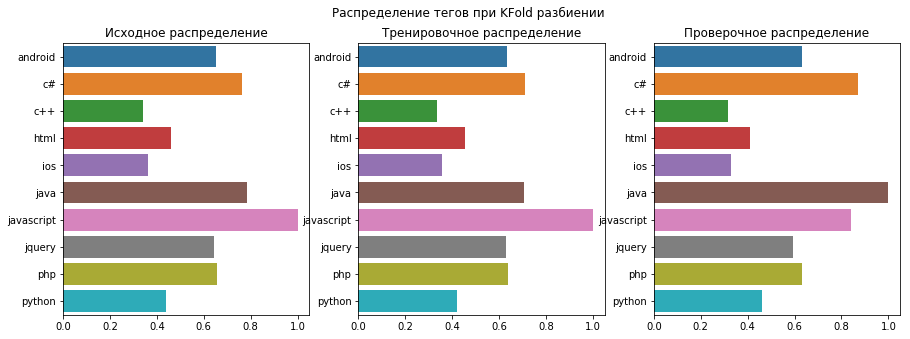

In [7]:
display_kfold_split(small_data)

Теперь, как видно, подвыборки имеют разные распределения тегов.

В библиотеке [iterative-stratification](https://github.com/trent-b/iterative-stratification) реализованы следующие классы :
- `MultilabelStratifiedKFold` (наследованый от `sklearn.model_selection._split._BaseKFold`)
- `MultilabelStratifiedShuffleSplit` (наследованый от `sklearn.model_selection._split.BaseShuffleSplit`)
- `RepeatedMultilabelStratifiedKFold` (наследованый от `sklearn.model_selection._split._RepeatedSplits`)


Вначале запустим стратификацию и посмотрим на полученный результат.

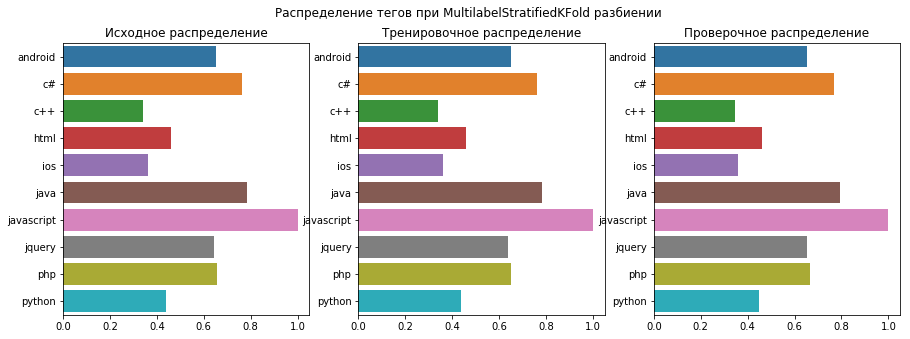

In [8]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

splt = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

y = small_data[unique_tags]
X = np.zeros((len(small_data), 1))

for train_index, test_index in splt.split(X, y):
    break

tags_counts = small_data[unique_tags].sum(axis=0)
tags_counts = tags_counts / tags_counts.max()

train_tags_counts = small_data.loc[train_index, unique_tags].sum(axis=0)
train_tags_counts = train_tags_counts / train_tags_counts.max()

test_tags_counts = small_data.loc[test_index, unique_tags].sum(axis=0)
test_tags_counts = test_tags_counts / test_tags_counts.max()

fig = plt.figure(figsize=(15, 5))
plt.suptitle("Распределение тегов при MultilabelStratifiedKFold разбиении")
plt.subplot(1,3,1)
plt.title("Исходное распределение")
sns.barplot(x=tags_counts, y=unique_tags, orient='h')
plt.subplot(1,3,2)
plt.title("Тренировочное распределение")
sns.barplot(x=train_tags_counts, y=unique_tags, orient='h')
plt.subplot(1,3,3)
plt.title("Проверочное распределение")
sns.barplot(x=test_tags_counts, y=unique_tags, orient='h')

Мы видим, что алгоритм сохраняет распределение классов в подвыборках. И это хорошо!

Теперь, разберем в деталях реализацию алгоритма и интерактивно посмотрим как происходит разбиение. Итак, у нас на входе `y` и количество разбиений `n_splits`.

In [9]:
n_splits = 5
n_samples = y.shape[0]
y.shape, n_splits

((2000, 10), 5)

Сначала оценим сколько элементов исходной выборки может попасть в каждый сплит (подвыборку):

In [10]:
r = np.asarray([1 / n_splits] * n_splits)
c_folds = r * n_samples
c_folds

array([400., 400., 400., 400., 400.])

Это теоретическое значение является верхней границей.
Затем оценим количество элементов каждого класса в каждой подвыборке. 

In [11]:
c_folds_labels = np.outer(r, y.sum(axis=0))
c_folds_labels

array([[51. , 59.6, 26.6, 36. , 28.2, 61.4, 78.2, 50.2, 51.2, 34.4],
       [51. , 59.6, 26.6, 36. , 28.2, 61.4, 78.2, 50.2, 51.2, 34.4],
       [51. , 59.6, 26.6, 36. , 28.2, 61.4, 78.2, 50.2, 51.2, 34.4],
       [51. , 59.6, 26.6, 36. , 28.2, 61.4, 78.2, 50.2, 51.2, 34.4],
       [51. , 59.6, 26.6, 36. , 28.2, 61.4, 78.2, 50.2, 51.2, 34.4]])

Таким образом, мы оценили, что количество элементов, содержащих тег "android" в каждой тестовой подвыборке (из 5 фолдов): 

In [12]:
c_folds_labels[:, 0]

array([51., 51., 51., 51., 51.])

Теперь посмотрим в интерактивном режиме как заполняются подвыборки.


*В следующей клетке должна появиться кнопка "Вперед", при нажатии которой, графики распределения тегов обновляются на каждом этапе поиска редкий тегов. Данный функционал требует наличие установленного [`ipywidgets`](https://ipywidgets.readthedocs.io/en/latest/index.html). Если, кнопка не появляется, то возможно нужно установить библиотку и включить дополнения:*
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```
*В докере festline данный пакет присутствует и вышеописанная визуализация функционирует :)*

In [13]:
from ipywidgets import interactive
from IPython.display import display


random_state = np.random.RandomState(12345)
labels = np.asarray(y.values, dtype=bool)
folds = np.zeros((n_splits, labels.shape[1]), dtype=np.int)
remaining_labels_mask = np.ones(n_samples, dtype=bool)
r = np.asarray([1 / n_splits] * n_splits)
c_folds = r * n_samples
c_folds_labels = np.outer(r, labels.sum(axis=0))


def draw():
    plt.figure(figsize=(20, 5))
    for i in range(n_splits):
        plt.subplot(1,n_splits, i + 1)
        plt.title("Подвыборка {}".format(i))
        sns.barplot(x=folds[i, :], y=unique_tags, orient='h')
        plt.xlim((0, 100))
        if i > 0:
            plt.yticks([])

            
def go_forward():
    if not np.any(remaining_labels_mask):
        print("Конец процедуры")
        return
    num_labels = labels[remaining_labels_mask].sum(axis=0)
    if num_labels.sum() == 0:
        sample_idxs = np.where(remaining_labels_mask)[0]
        for sample_idx in sample_idxs:
            fold_idx = np.where(c_folds == c_folds.max())[0]
            if fold_idx.shape[0] > 1:
                fold_idx = [fold_idx[random_state.choice(fold_idx.shape[0])]]
            folds[fold_idx[0], :] += labels[sample_idx]
            c_folds[fold_idx] -= 1
        return    
    label_idx = np.where(num_labels == num_labels[np.nonzero(num_labels)].min())[0]
    if label_idx.shape[0] > 1:
        label_idx = label_idx[random_state.choice(label_idx.shape[0])]
    sample_idxs = np.where(np.logical_and(labels[:, label_idx].flatten(), remaining_labels_mask))[0]

    print("Найден 'редкий' класс: {} и {} элементов, сожержащих этот класс"
          .format(unique_tags[label_idx[0]], len(sample_idxs)))
    print("Элементы будут распределены по нуждающимся выборкам")
    for sample_idx in sample_idxs:
        label_folds = c_folds_labels[:, label_idx]
        fold_idx = np.where(label_folds == label_folds.max())[0]
        if fold_idx.shape[0] > 1:
            temp_fold_idx = np.where(c_folds[fold_idx] == c_folds[fold_idx].max())[0]
            fold_idx = fold_idx[temp_fold_idx]
            if temp_fold_idx.shape[0] > 1:
                fold_idx = [fold_idx[random_state.choice(temp_fold_idx.shape[0])]]
                
        folds[fold_idx[0], :] += labels[sample_idx]        
        remaining_labels_mask[sample_idx] = False        
        c_folds_labels[fold_idx, labels[sample_idx]] -= 1
        c_folds[fold_idx] -= 1

    print("Остаток элементов по классам в подвыборке: \n{}".format(c_folds_labels))

    
def interact_draw():
    go_forward()
    draw()

    
options = dict(manual=True, auto_display=True)
interact_manual = interactive(interact_draw, options)
interact_manual.manual_button.description = "Вперед"
interact_manual

interactive(children=(Button(description='Вперед', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Заключение

Цель данного обзора - познакомиться с одним из методов разбиения данных с пересекающимися классами. Естественно, что качество исходного набора будет влиять на качество стратификации. 
Плюсы алгоритма (от авторов алгоритма): 
- сохраняет дисбаланс классов в подвыборках
- применимся в случае, когда уникальных комбинаций классов соизмеримо много с количеством данных

### Еще о применении

Данный функционал может быть также использован для разбиения датасетов с изображениями и разметкой в виде а) мультиклассовая сегментационная маска объектов или б) мультиклассовые прямоугольники.
Для этих данных алгоритм можно усовершенствовать и добавить размер объекта как "вес" класса для каждого элемента данных.


## Ссылки:

- http://lpis.csd.auth.gr/publications/sechidis-ecmlpkdd-2011.pdf
- https://www.slideshare.net/tsoumakas/on-the-stratification-of-multilabel-data
- https://github.com/trent-b/iterative-stratification